# Part 1: Data Cleaning & Feature Engineering

## Precog Quant Task 2026 - Algorithmic Trading Pipeline

---

### Notebook Objectives

Following the scientific method of quantitative research:

1. **Data Ingestion** - Load and consolidate 100 asset CSVs
2. **Data Quality Assessment** - Identify missing values, outliers, anomalies
3. **Exploratory Data Analysis** - Statistical profiling without premature inference
4. **Hypothesis Generation** - Document observations for later testing
5. **Data Cleaning** - Implement cleaning strategies with justification
6. **Feature Engineering** - Generate features capturing market dynamics

### Scientific Method Approach

> "In this business it's easy to confuse luck with brains." - Jim Simons

We will:
- **Observe** before concluding
- **Document** all findings, including negative results
- **Justify** every decision with data
- **Question** any result that seems too good

---

## 1. Environment Setup & Configuration

In [12]:
pip install scipy numpy pandas seaborn matplotlib tqdm ipywidgets

  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)
Using cached widgetsnbextension-4.0.15-py3-none-any.whl (2.2 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# =============================================================================
# IMPORTS & CONFIGURATION
# =============================================================================

import os
import sys
import warnings
from pathlib import Path
from glob import glob
from typing import Dict, List, Tuple, Optional

# Core Data Science
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.6f}'.format)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Random seed set to: {RANDOM_SEED}")

NumPy version: 2.3.2
Pandas version: 2.3.2
Random seed set to: 42


In [16]:
# =============================================================================
# PROJECT PATHS
# =============================================================================

# Define project structure
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
ASSETS_DIR = DATA_RAW / 'assets'
OUTPUT_FIGURES = PROJECT_ROOT / 'outputs' / 'figures'
OUTPUT_RESULTS = PROJECT_ROOT / 'outputs' / 'results'

# Verify paths exist
print("=" * 60)
print("PROJECT DIRECTORY STRUCTURE VERIFICATION")
print("=" * 60)
paths_to_check = {
    'Project Root': PROJECT_ROOT,
    'Raw Data': DATA_RAW,
    'Assets Directory': ASSETS_DIR,
    'Processed Data': DATA_PROCESSED,
    'Output Figures': OUTPUT_FIGURES,
    'Output Results': OUTPUT_RESULTS
}

for name, path in paths_to_check.items():
    status = "✓" if path.exists() else "✗"
    print(f"{status} {name}: {path}")

PROJECT DIRECTORY STRUCTURE VERIFICATION
✓ Project Root: c:\Users\ponna\OneDrive\Desktop\Precog Task
✓ Raw Data: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\raw
✓ Assets Directory: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\raw\assets
✓ Processed Data: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed
✓ Output Figures: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\figures
✓ Output Results: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\results


## 2. Data Ingestion

### 2.1 Load Individual Asset Files

**Approach:** Load all 100 CSVs, inspect structure, and consolidate into a unified format.

**Questions to answer:**
- What is the structure of each CSV?
- Are all files consistent in format?
- What is the date range covered?
- What columns are available (OHLCV expected)?

In [17]:
# =============================================================================
# DATA LOADING UTILITIES
# =============================================================================

def get_asset_files(assets_dir: Path) -> List[Path]:
    """Get sorted list of all asset CSV files."""
    pattern = str(assets_dir / 'Asset_*.csv')
    files = sorted(glob(pattern))
    return [Path(f) for f in files]


def extract_asset_id(filepath: Path) -> str:
    """Extract asset identifier from filename."""
    # Assumes format: Asset_XXX.csv
    return filepath.stem  # Returns 'Asset_XXX'


def load_single_asset(filepath: Path, parse_dates: bool = True) -> pd.DataFrame:
    """Load a single asset CSV with basic preprocessing."""
    df = pd.read_csv(filepath)
    
    # Add asset identifier
    df['asset_id'] = extract_asset_id(filepath)
    
    return df


def inspect_file_structure(filepath: Path) -> Dict:
    """Inspect a single file's structure without loading entirely."""
    df = pd.read_csv(filepath, nrows=5)
    return {
        'filename': filepath.name,
        'columns': list(df.columns),
        'dtypes': df.dtypes.to_dict(),
        'n_cols': len(df.columns)
    }

In [18]:
# =============================================================================
# DISCOVER AND INSPECT ASSET FILES
# =============================================================================

# Get all asset files
asset_files = get_asset_files(ASSETS_DIR)
n_assets = len(asset_files)

print("=" * 60)
print("ASSET FILE DISCOVERY")
print("=" * 60)
print(f"Total asset files found: {n_assets}")
print(f"\nFirst 5 files: {[f.name for f in asset_files[:5]]}")
print(f"Last 5 files: {[f.name for f in asset_files[-5:]]}")

ASSET FILE DISCOVERY
Total asset files found: 100

First 5 files: ['Asset_001.csv', 'Asset_002.csv', 'Asset_003.csv', 'Asset_004.csv', 'Asset_005.csv']
Last 5 files: ['Asset_096.csv', 'Asset_097.csv', 'Asset_098.csv', 'Asset_099.csv', 'Asset_100.csv']


In [19]:
# =============================================================================
# INSPECT FILE STRUCTURE CONSISTENCY
# =============================================================================

print("=" * 60)
print("FILE STRUCTURE INSPECTION")
print("=" * 60)

# Inspect first file in detail
sample_file = asset_files[0]
sample_structure = inspect_file_structure(sample_file)

print(f"\nSample file: {sample_structure['filename']}")
print(f"Columns ({sample_structure['n_cols']}): {sample_structure['columns']}")
print(f"\nData types:")
for col, dtype in sample_structure['dtypes'].items():
    print(f"  {col}: {dtype}")

# Check consistency across all files
print("\n" + "=" * 60)
print("CHECKING COLUMN CONSISTENCY ACROSS ALL FILES")
print("=" * 60)

column_sets = {}
for f in tqdm(asset_files, desc="Inspecting files"):
    structure = inspect_file_structure(f)
    col_tuple = tuple(structure['columns'])
    if col_tuple not in column_sets:
        column_sets[col_tuple] = []
    column_sets[col_tuple].append(f.name)

print(f"\nUnique column structures found: {len(column_sets)}")
for cols, files in column_sets.items():
    print(f"\nColumns: {cols}")
    print(f"  Files with this structure: {len(files)}")
    if len(files) <= 5:
        print(f"  Files: {files}")

Exception ignored in: <function tqdm.__del__ at 0x00000295D43F8B80>
Traceback (most recent call last):
  File "c:\Users\ponna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\ponna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x00000295D43F8B80>
Traceback (most recent call last):
  File "c:\Users\ponna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\ponna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


FILE STRUCTURE INSPECTION

Sample file: Asset_001.csv
Columns (6): ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

Data types:
  Date: object
  Open: float64
  High: float64
  Low: float64
  Close: float64
  Volume: int64

CHECKING COLUMN CONSISTENCY ACROSS ALL FILES


Inspecting files: 100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


Unique column structures found: 1

Columns: ('Date', 'Open', 'High', 'Low', 'Close', 'Volume')
  Files with this structure: 100


In [20]:
# =============================================================================
# LOAD SAMPLE FILE FOR DETAILED INSPECTION
# =============================================================================

# Load one file completely to understand structure
sample_df = pd.read_csv(asset_files[0])

print("=" * 60)
print("DETAILED SAMPLE FILE INSPECTION")
print("=" * 60)
print(f"\nFile: {asset_files[0].name}")
print(f"Shape: {sample_df.shape}")
print(f"\nFirst 10 rows:")
display(sample_df.head(10))
print(f"\nLast 10 rows:")
display(sample_df.tail(10))
print(f"\nInfo:")
sample_df.info()

DETAILED SAMPLE FILE INSPECTION

File: Asset_001.csv
Shape: (2511, 6)

First 10 rows:


,Date,Open,High,Low,Close,Volume
0,2016-01-25,29.178415,29.181290,28.514486,28.580592,249449990
1,2016-01-26,28.721415,28.994458,28.186822,28.738659,361581962
2,2016-01-27,27.603374,27.772948,26.827351,26.850345,642328247
3,2016-01-28,26.956690,27.166502,26.554308,27.042913,268157355
4,2016-01-29,27.244108,27.977016,27.117645,27.977016,310239413
5,2016-02-01,27.726962,27.795941,27.419428,27.715465,197189966
6,2016-02-02,27.425174,27.603372,27.097520,27.155005,179917813
7,2016-02-03,27.304454,27.833297,27.040032,27.692464,221370883
8,2016-02-04,27.701143,28.125937,27.507531,27.914984,223814596
9,2016-02-05,27.891858,28.007448,27.074060,27.169420,223556451



Last 10 rows:


,Date,Open,High,Low,Close,Volume
2501,2026-01-05,344.996943,346.105965,339.260591,340.688299,54960920
2502,2026-01-06,340.356853,341.057947,334.136093,334.442019,63033868
2503,2026-01-07,335.512839,336.124691,331.191435,331.854289,58166789
2504,2026-01-08,327.634887,330.528582,325.952234,330.209896,60706705
2505,2026-01-09,330.260858,331.701325,326.615106,330.630544,48157870
2506,2026-01-12,330.362859,333.090793,327.354441,331.752326,54499292
2507,2026-01-13,329.801968,333.740925,329.381320,332.772106,55061578
2508,2026-01-14,330.783508,333.753685,327.239719,331.382639,48184840
2509,2026-01-15,332.262216,332.759385,327.673127,329.151836,47425334
2510,2026-01-16,328.756668,330.031413,324.970675,325.735529,86713063



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2511 non-null   object 
 1   Open    2511 non-null   float64
 2   High    2511 non-null   float64
 3   Low     2511 non-null   float64
 4   Close   2511 non-null   float64
 5   Volume  2511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 117.8+ KB


In [21]:
# =============================================================================
# LOAD ALL ASSETS INTO UNIFIED DATAFRAME
# =============================================================================

def load_all_assets(asset_files: List[Path], verbose: bool = True) -> pd.DataFrame:
    """
    Load all asset CSVs into a single DataFrame.
    
    Returns:
        DataFrame with MultiIndex or asset_id column for identification
    """
    all_dfs = []
    
    iterator = tqdm(asset_files, desc="Loading assets") if verbose else asset_files
    
    for filepath in iterator:
        df = load_single_asset(filepath)
        all_dfs.append(df)
    
    # Concatenate all DataFrames
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    return combined_df


# Load all data
print("=" * 60)
print("LOADING ALL ASSET DATA")
print("=" * 60)

df_raw = load_all_assets(asset_files)

print(f"\n✓ Data loaded successfully!")
print(f"  Total rows: {len(df_raw):,}")
print(f"  Total columns: {len(df_raw.columns)}")
print(f"  Unique assets: {df_raw['asset_id'].nunique()}")
print(f"  Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

LOADING ALL ASSET DATA


Loading assets: 100%|██████████| 100/100 [00:00<00:00, 257.59it/s]



✓ Data loaded successfully!
  Total rows: 251,100
  Total columns: 7
  Unique assets: 100
  Memory usage: 37.60 MB


## 3. Data Quality Assessment

### Scientific Approach

We systematically assess data quality across multiple dimensions:

1. **Completeness** - Missing values, gaps in time series
2. **Validity** - Data types, value ranges, OHLC relationships
3. **Consistency** - Cross-asset comparison, date alignment
4. **Accuracy** - Outlier detection, anomaly identification

> **Principle:** Document observations. Do not clean until we understand what we're dealing with.

In [22]:
# =============================================================================
# DATA QUALITY ASSESSMENT UTILITIES
# =============================================================================

class DataQualityAssessor:
    """
    Comprehensive data quality assessment for financial time series.
    
    Following the principle: Observe first, clean later.
    """
    
    def __init__(self, df: pd.DataFrame, date_col: str = None, asset_col: str = 'asset_id'):
        self.df = df.copy()
        self.date_col = date_col
        self.asset_col = asset_col
        self.quality_report = {}
        
    def assess_completeness(self) -> pd.DataFrame:
        """Assess missing values and data completeness."""
        
        # Overall missing values
        missing_stats = pd.DataFrame({
            'total_count': len(self.df),
            'missing_count': self.df.isnull().sum(),
            'missing_pct': (self.df.isnull().sum() / len(self.df) * 100).round(4),
            'dtype': self.df.dtypes
        })
        
        self.quality_report['completeness'] = missing_stats
        return missing_stats
    
    def assess_completeness_by_asset(self) -> pd.DataFrame:
        """Assess missing values per asset."""
        
        missing_by_asset = self.df.groupby(self.asset_col).apply(
            lambda x: x.isnull().sum()
        )
        
        self.quality_report['completeness_by_asset'] = missing_by_asset
        return missing_by_asset
    
    def assess_value_ranges(self, numeric_cols: List[str] = None) -> pd.DataFrame:
        """Assess value ranges for numeric columns."""
        
        if numeric_cols is None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        range_stats = self.df[numeric_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
        range_stats['range'] = range_stats['max'] - range_stats['min']
        range_stats['iqr'] = range_stats['75%'] - range_stats['25%']
        range_stats['has_negative'] = (self.df[numeric_cols] < 0).any()
        range_stats['has_zero'] = (self.df[numeric_cols] == 0).any()
        
        self.quality_report['value_ranges'] = range_stats
        return range_stats
    
    def assess_duplicates(self) -> Dict:
        """Check for duplicate rows."""
        
        n_total = len(self.df)
        n_duplicates = self.df.duplicated().sum()
        
        # Check duplicates by date + asset
        if self.date_col and self.date_col in self.df.columns:
            n_date_asset_dups = self.df.duplicated(subset=[self.date_col, self.asset_col]).sum()
        else:
            n_date_asset_dups = None
        
        dup_report = {
            'total_rows': n_total,
            'duplicate_rows': n_duplicates,
            'duplicate_pct': n_duplicates / n_total * 100,
            'date_asset_duplicates': n_date_asset_dups
        }
        
        self.quality_report['duplicates'] = dup_report
        return dup_report
    
    def assess_data_types(self) -> pd.DataFrame:
        """Assess data types and potential type issues."""
        
        dtype_info = pd.DataFrame({
            'dtype': self.df.dtypes,
            'n_unique': self.df.nunique(),
            'sample_values': self.df.apply(lambda x: list(x.dropna().head(3).values))
        })
        
        self.quality_report['dtypes'] = dtype_info
        return dtype_info
    
    def get_summary(self) -> Dict:
        """Get complete quality assessment summary."""
        return self.quality_report

In [23]:
# =============================================================================
# RUN DATA QUALITY ASSESSMENT
# =============================================================================

# Identify date column (may vary based on actual data)
potential_date_cols = ['Date', 'date', 'DATE', 'Datetime', 'datetime', 'timestamp', 'time']
date_col = None
for col in potential_date_cols:
    if col in df_raw.columns:
        date_col = col
        break

print(f"Identified date column: {date_col}")

# Initialize assessor
assessor = DataQualityAssessor(df_raw, date_col=date_col, asset_col='asset_id')

print("\n" + "=" * 60)
print("DATA QUALITY ASSESSMENT")
print("=" * 60)

Identified date column: Date

DATA QUALITY ASSESSMENT


In [24]:
# =============================================================================
# 3.1 COMPLETENESS ASSESSMENT
# =============================================================================

print("\n" + "-" * 40)
print("3.1 COMPLETENESS ASSESSMENT")
print("-" * 40)

completeness = assessor.assess_completeness()
display(completeness)

# Observation logging
missing_cols = completeness[completeness['missing_count'] > 0]
if len(missing_cols) > 0:
    print("\n📋 OBSERVATION: Columns with missing values detected:")
    for col in missing_cols.index:
        print(f"  - {col}: {missing_cols.loc[col, 'missing_count']:,} missing ({missing_cols.loc[col, 'missing_pct']:.2f}%)")
else:
    print("\n📋 OBSERVATION: No missing values detected in any column.")


----------------------------------------
3.1 COMPLETENESS ASSESSMENT
----------------------------------------


,total_count,missing_count,missing_pct,dtype
Date,251100,0,0.000000,object
Open,251100,0,0.000000,float64
High,251100,0,0.000000,float64
Low,251100,0,0.000000,float64
Close,251100,0,0.000000,float64
Volume,251100,0,0.000000,int64
asset_id,251100,0,0.000000,object



📋 OBSERVATION: No missing values detected in any column.


In [25]:
# =============================================================================
# 3.2 COMPLETENESS BY ASSET
# =============================================================================

print("\n" + "-" * 40)
print("3.2 COMPLETENESS BY ASSET")
print("-" * 40)

completeness_by_asset = assessor.assess_completeness_by_asset()

# Summary statistics
rows_per_asset = df_raw.groupby('asset_id').size()

print(f"\nRows per asset statistics:")
print(f"  Min:    {rows_per_asset.min():,}")
print(f"  Max:    {rows_per_asset.max():,}")
print(f"  Mean:   {rows_per_asset.mean():,.1f}")
print(f"  Median: {rows_per_asset.median():,.1f}")
print(f"  Std:    {rows_per_asset.std():,.1f}")

# Check if all assets have same number of rows
if rows_per_asset.nunique() == 1:
    print("\n📋 OBSERVATION: All assets have identical row counts - data is aligned.")
else:
    print("\n📋 OBSERVATION: Assets have varying row counts - potential date misalignment.")
    print(f"   Unique row counts: {rows_per_asset.nunique()}")


----------------------------------------
3.2 COMPLETENESS BY ASSET
----------------------------------------

Rows per asset statistics:
  Min:    2,511
  Max:    2,511
  Mean:   2,511.0
  Median: 2,511.0
  Std:    0.0

📋 OBSERVATION: All assets have identical row counts - data is aligned.


In [26]:
# =============================================================================
# 3.3 VALUE RANGES ASSESSMENT
# =============================================================================

print("\n" + "-" * 40)
print("3.3 VALUE RANGES ASSESSMENT")
print("-" * 40)

value_ranges = assessor.assess_value_ranges()
display(value_ranges)


----------------------------------------
3.3 VALUE RANGES ASSESSMENT
----------------------------------------


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,range,iqr,has_negative,has_zero
Open,251100.000000,171.270353,221.766675,0.791579,8.036461,19.433295,54.185446,110.209685,212.850350,516.489244,991.423551,3805.550413,3804.758834,158.664904,False,False
High,251100.000000,173.051687,224.161517,0.816496,8.147874,19.645254,54.724209,111.337786,214.933329,521.946851,1000.745937,3821.525319,3820.708824,160.209120,False,False
Low,251100.000000,169.462270,219.350681,0.790621,7.919221,19.239465,53.607201,109.047275,210.755907,511.275374,980.999734,3735.480171,3734.689550,157.148706,False,False
Close,251100.000000,171.301702,221.831319,0.805635,8.030477,19.436545,54.195624,110.240933,212.929063,516.776467,992.703335,3806.152646,3805.347012,158.733439,False,False
Volume,251100.000000,16117050.030490,46062424.247279,0.000000,290751.990000,753856.100000,2321001.500000,4760036.000000,13079057.500000,58944381.300000,206058310.650001,2828707551.000000,2828707551.000000,10758056.000000,False,True


In [27]:
# =============================================================================
# 3.4 DUPLICATE ASSESSMENT
# =============================================================================

print("\n" + "-" * 40)
print("3.4 DUPLICATE ASSESSMENT")
print("-" * 40)

duplicates = assessor.assess_duplicates()
for key, value in duplicates.items():
    print(f"  {key}: {value}")


----------------------------------------
3.4 DUPLICATE ASSESSMENT
----------------------------------------
  total_rows: 251100
  duplicate_rows: 0
  duplicate_pct: 0.0
  date_asset_duplicates: 0


In [28]:
# =============================================================================
# 3.5 DATA TYPES ASSESSMENT
# =============================================================================

print("\n" + "-" * 40)
print("3.5 DATA TYPES ASSESSMENT")
print("-" * 40)

dtype_info = assessor.assess_data_types()
display(dtype_info)


----------------------------------------
3.5 DATA TYPES ASSESSMENT
----------------------------------------


ValueError: 2

## 4. Exploratory Data Analysis (EDA)

### Approach

We explore the data systematically without making premature conclusions:

1. **Temporal Analysis** - Date ranges, trading days, gaps
2. **Price Analysis** - Distribution, cross-asset comparison
3. **Volume Analysis** - Patterns, anomalies
4. **OHLC Relationships** - Validity checks
5. **Return Analysis** - Distribution, stationarity
6. **Cross-Asset Analysis** - Correlations, clustering patterns

In [29]:
# =============================================================================
# PREPARE DATA FOR EDA
# =============================================================================

# Create a working copy
df = df_raw.copy()

# Parse dates if date column exists
if date_col:
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([date_col, 'asset_id']).reset_index(drop=True)
    print(f"Parsed date column: {date_col}")
    print(f"Date range: {df[date_col].min()} to {df[date_col].max()}")

# Identify OHLCV columns
ohlcv_mapping = {}
potential_mappings = {
    'open': ['Open', 'open', 'OPEN', 'o'],
    'high': ['High', 'high', 'HIGH', 'h'],
    'low': ['Low', 'low', 'LOW', 'l'],
    'close': ['Close', 'close', 'CLOSE', 'c', 'Adj Close', 'adj_close'],
    'volume': ['Volume', 'volume', 'VOLUME', 'v', 'vol']
}

for ohlcv_type, possible_names in potential_mappings.items():
    for name in possible_names:
        if name in df.columns:
            ohlcv_mapping[ohlcv_type] = name
            break

print(f"\nIdentified OHLCV columns: {ohlcv_mapping}")

Parsed date column: Date
Date range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00

Identified OHLCV columns: {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}


In [30]:
# =============================================================================
# 4.1 TEMPORAL ANALYSIS
# =============================================================================

print("\n" + "=" * 60)
print("4.1 TEMPORAL ANALYSIS")
print("=" * 60)

if date_col:
    # Date range analysis
    date_analysis = {
        'start_date': df[date_col].min(),
        'end_date': df[date_col].max(),
        'total_days': (df[date_col].max() - df[date_col].min()).days,
        'unique_dates': df[date_col].nunique(),
    }
    
    print(f"\nDate Range Analysis:")
    for key, value in date_analysis.items():
        print(f"  {key}: {value}")
    
    # Trading days per year
    df['year'] = df[date_col].dt.year
    trading_days_per_year = df.groupby('year')[date_col].nunique()
    print(f"\nTrading days per year:")
    display(trading_days_per_year)
    
    # Check for gaps in dates
    unique_dates = df[date_col].sort_values().unique()
    date_diffs = np.diff(unique_dates).astype('timedelta64[D]').astype(int)
    
    print(f"\nDate gap analysis (consecutive trading days):")
    print(f"  Min gap: {date_diffs.min()} days")
    print(f"  Max gap: {date_diffs.max()} days")
    print(f"  Mean gap: {date_diffs.mean():.2f} days")
    print(f"  Median gap: {np.median(date_diffs)} days")
    
    # Large gaps (potential market closures, holidays)
    large_gaps = np.where(date_diffs > 5)[0]
    if len(large_gaps) > 0:
        print(f"\n📋 OBSERVATION: Found {len(large_gaps)} gaps > 5 days (weekends excluded):")
        for idx in large_gaps[:10]:  # Show first 10
            print(f"    {unique_dates[idx]} to {unique_dates[idx+1]} ({date_diffs[idx]} days)")


4.1 TEMPORAL ANALYSIS

Date Range Analysis:
  start_date: 2016-01-25 00:00:00
  end_date: 2026-01-16 00:00:00
  total_days: 3644
  unique_dates: 2511

Trading days per year:


year
2016    238
2017    251
2018    251
2019    252
2020    253
2021    252
2022    251
2023    250
2024    252
2025    250
2026     11
Name: Date, dtype: int64


Date gap analysis (consecutive trading days):
  Min gap: 1 days
  Max gap: 4 days
  Mean gap: 1.45 days
  Median gap: 1.0 days



4.2 PRICE DISTRIBUTION ANALYSIS


Exception ignored in: <function tqdm.__del__ at 0x00000295D43F8B80>
Traceback (most recent call last):
  File "c:\Users\ponna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
  File "c:\Users\ponna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


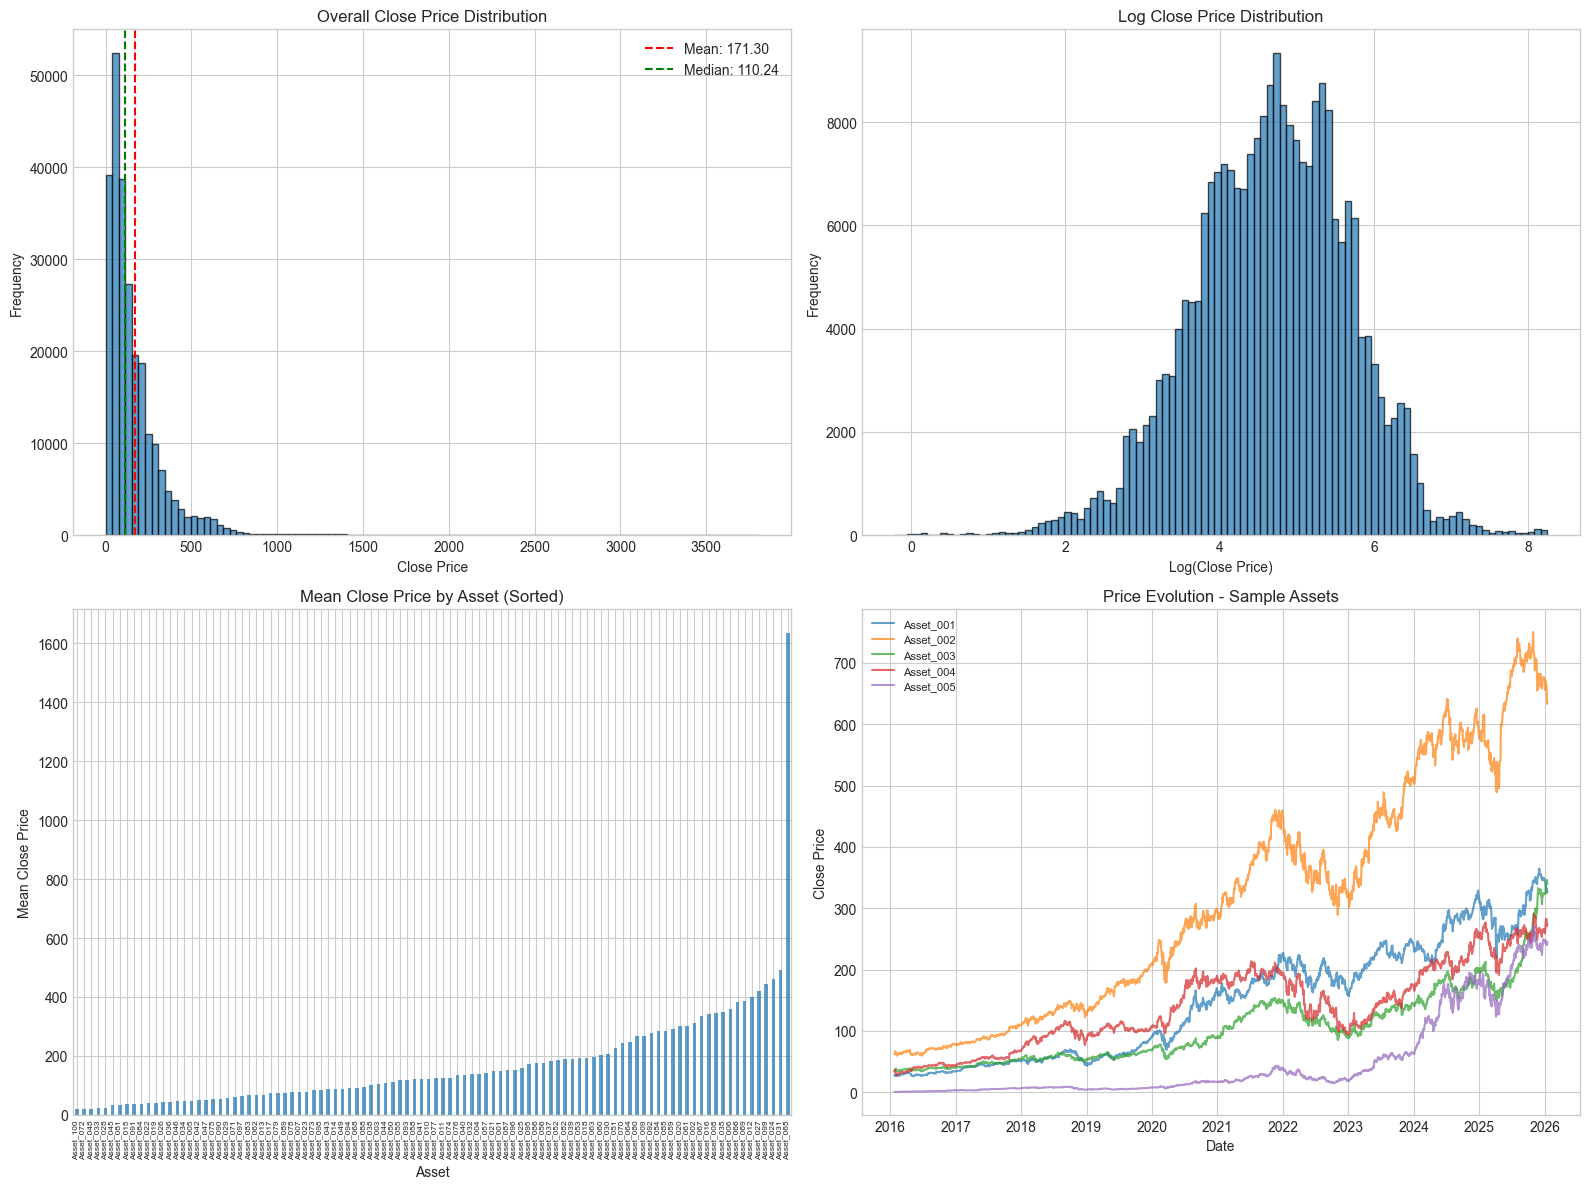


Close Price Statistics:
count   251100.000000
mean       171.301702
std        221.831319
min          0.805635
25%         54.195624
50%        110.240933
75%        212.929063
max       3806.152646
Name: Close, dtype: float64


In [31]:
# =============================================================================
# 4.2 PRICE DISTRIBUTION ANALYSIS
# =============================================================================

print("\n" + "=" * 60)
print("4.2 PRICE DISTRIBUTION ANALYSIS")
print("=" * 60)

close_col = ohlcv_mapping.get('close')

if close_col:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Overall price distribution
    ax1 = axes[0, 0]
    df[close_col].hist(bins=100, ax=ax1, edgecolor='black', alpha=0.7)
    ax1.set_title('Overall Close Price Distribution')
    ax1.set_xlabel('Close Price')
    ax1.set_ylabel('Frequency')
    ax1.axvline(df[close_col].mean(), color='r', linestyle='--', label=f'Mean: {df[close_col].mean():.2f}')
    ax1.axvline(df[close_col].median(), color='g', linestyle='--', label=f'Median: {df[close_col].median():.2f}')
    ax1.legend()
    
    # Log-scale distribution
    ax2 = axes[0, 1]
    log_prices = np.log(df[close_col].replace(0, np.nan).dropna())
    log_prices.hist(bins=100, ax=ax2, edgecolor='black', alpha=0.7)
    ax2.set_title('Log Close Price Distribution')
    ax2.set_xlabel('Log(Close Price)')
    ax2.set_ylabel('Frequency')
    
    # Price range by asset (boxplot)
    ax3 = axes[1, 0]
    asset_prices = df.groupby('asset_id')[close_col].agg(['mean', 'min', 'max'])
    asset_prices['mean'].sort_values().plot(kind='bar', ax=ax3, alpha=0.7)
    ax3.set_title('Mean Close Price by Asset (Sorted)')
    ax3.set_xlabel('Asset')
    ax3.set_ylabel('Mean Close Price')
    ax3.tick_params(axis='x', rotation=90, labelsize=6)
    
    # Price evolution over time (sample assets)
    ax4 = axes[1, 1]
    if date_col:
        sample_assets = df['asset_id'].unique()[:5]  # First 5 assets
        for asset in sample_assets:
            asset_data = df[df['asset_id'] == asset]
            ax4.plot(asset_data[date_col], asset_data[close_col], label=asset, alpha=0.7)
        ax4.set_title('Price Evolution - Sample Assets')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Close Price')
        ax4.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FIGURES / 'price_distribution_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Statistical summary
    print(f"\nClose Price Statistics:")
    print(df[close_col].describe())


4.3 VOLUME ANALYSIS


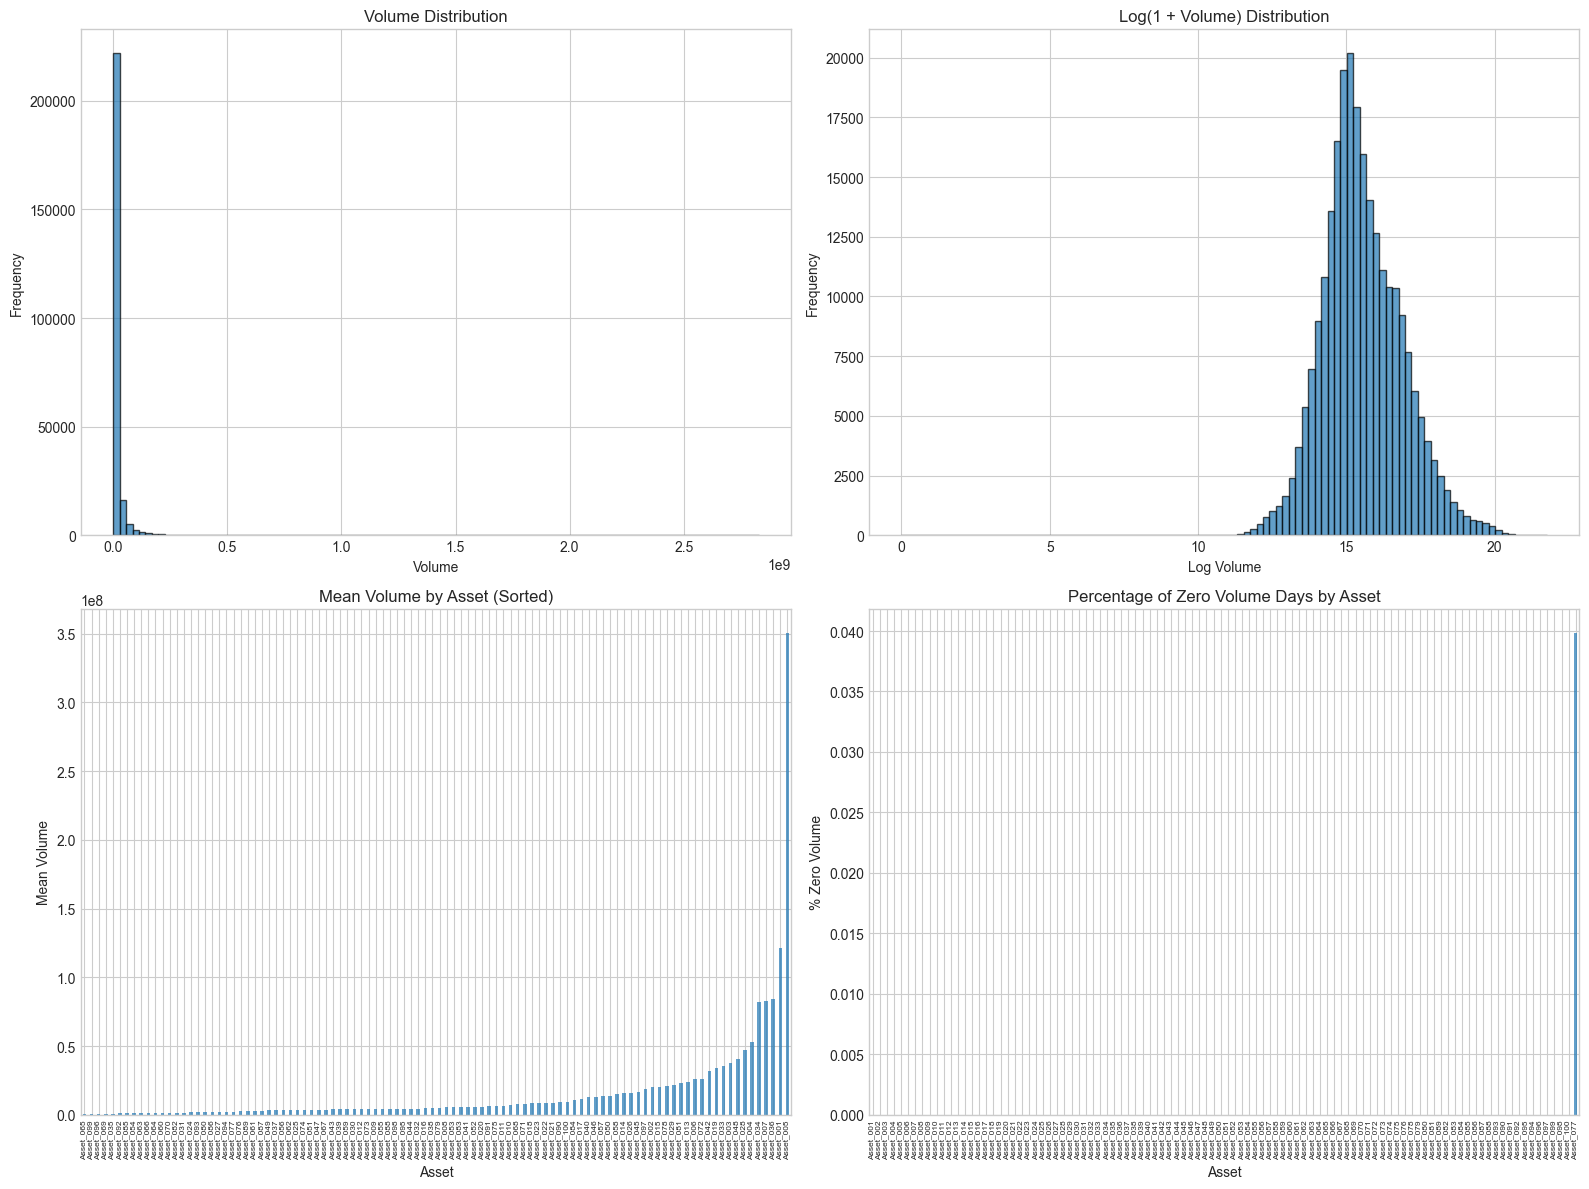


📋 OBSERVATION: Zero volume records: 1 (0.00%)
   Assets with highest zero volume %:
asset_id
Asset_077   0.039825
Asset_001   0.000000
Asset_002   0.000000
Asset_003   0.000000
Asset_004   0.000000
dtype: float64


In [32]:
# =============================================================================
# 4.3 VOLUME ANALYSIS
# =============================================================================

print("\n" + "=" * 60)
print("4.3 VOLUME ANALYSIS")
print("=" * 60)

volume_col = ohlcv_mapping.get('volume')

if volume_col:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Volume distribution
    ax1 = axes[0, 0]
    df[volume_col].hist(bins=100, ax=ax1, edgecolor='black', alpha=0.7)
    ax1.set_title('Volume Distribution')
    ax1.set_xlabel('Volume')
    ax1.set_ylabel('Frequency')
    
    # Log volume distribution
    ax2 = axes[0, 1]
    log_volume = np.log1p(df[volume_col])  # log(1+x) to handle zeros
    log_volume.hist(bins=100, ax=ax2, edgecolor='black', alpha=0.7)
    ax2.set_title('Log(1 + Volume) Distribution')
    ax2.set_xlabel('Log Volume')
    ax2.set_ylabel('Frequency')
    
    # Volume by asset
    ax3 = axes[1, 0]
    asset_volumes = df.groupby('asset_id')[volume_col].mean().sort_values()
    asset_volumes.plot(kind='bar', ax=ax3, alpha=0.7)
    ax3.set_title('Mean Volume by Asset (Sorted)')
    ax3.set_xlabel('Asset')
    ax3.set_ylabel('Mean Volume')
    ax3.tick_params(axis='x', rotation=90, labelsize=6)
    
    # Zero volume days
    ax4 = axes[1, 1]
    zero_volume_pct = df.groupby('asset_id').apply(lambda x: (x[volume_col] == 0).sum() / len(x) * 100)
    zero_volume_pct.sort_values().plot(kind='bar', ax=ax4, alpha=0.7)
    ax4.set_title('Percentage of Zero Volume Days by Asset')
    ax4.set_xlabel('Asset')
    ax4.set_ylabel('% Zero Volume')
    ax4.tick_params(axis='x', rotation=90, labelsize=6)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FIGURES / 'volume_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Zero volume summary
    total_zero_volume = (df[volume_col] == 0).sum()
    print(f"\n📋 OBSERVATION: Zero volume records: {total_zero_volume:,} ({total_zero_volume/len(df)*100:.2f}%)")
    
    if zero_volume_pct.max() > 0:
        print(f"   Assets with highest zero volume %:")
        print(zero_volume_pct.nlargest(5))

In [33]:
# =============================================================================
# 4.4 OHLC RELATIONSHIP VALIDATION
# =============================================================================

print("\n" + "=" * 60)
print("4.4 OHLC RELATIONSHIP VALIDATION")
print("=" * 60)

open_col = ohlcv_mapping.get('open')
high_col = ohlcv_mapping.get('high')
low_col = ohlcv_mapping.get('low')
close_col = ohlcv_mapping.get('close')

if all([open_col, high_col, low_col, close_col]):
    
    # OHLC relationship checks
    ohlc_checks = {
        'high >= low': (df[high_col] >= df[low_col]).all(),
        'high >= open': (df[high_col] >= df[open_col]).all(),
        'high >= close': (df[high_col] >= df[close_col]).all(),
        'low <= open': (df[low_col] <= df[open_col]).all(),
        'low <= close': (df[low_col] <= df[close_col]).all(),
    }
    
    print("\nOHLC Validity Checks:")
    for check, result in ohlc_checks.items():
        status = "✓ PASS" if result else "✗ FAIL"
        print(f"  {check}: {status}")
    
    # Count violations
    violations = {
        'high < low': (df[high_col] < df[low_col]).sum(),
        'high < open': (df[high_col] < df[open_col]).sum(),
        'high < close': (df[high_col] < df[close_col]).sum(),
        'low > open': (df[low_col] > df[open_col]).sum(),
        'low > close': (df[low_col] > df[close_col]).sum(),
    }
    
    total_violations = sum(violations.values())
    if total_violations > 0:
        print(f"\n📋 OBSERVATION: Found {total_violations} OHLC violations:")
        for violation, count in violations.items():
            if count > 0:
                print(f"    {violation}: {count} occurrences")
    else:
        print(f"\n📋 OBSERVATION: No OHLC relationship violations found.")


4.4 OHLC RELATIONSHIP VALIDATION

OHLC Validity Checks:
  high >= low: ✓ PASS
  high >= open: ✓ PASS
  high >= close: ✗ FAIL
  low <= open: ✗ FAIL
  low <= close: ✗ FAIL

📋 OBSERVATION: Found 19 OHLC violations:
    high < close: 8 occurrences
    low > open: 1 occurrences
    low > close: 10 occurrences


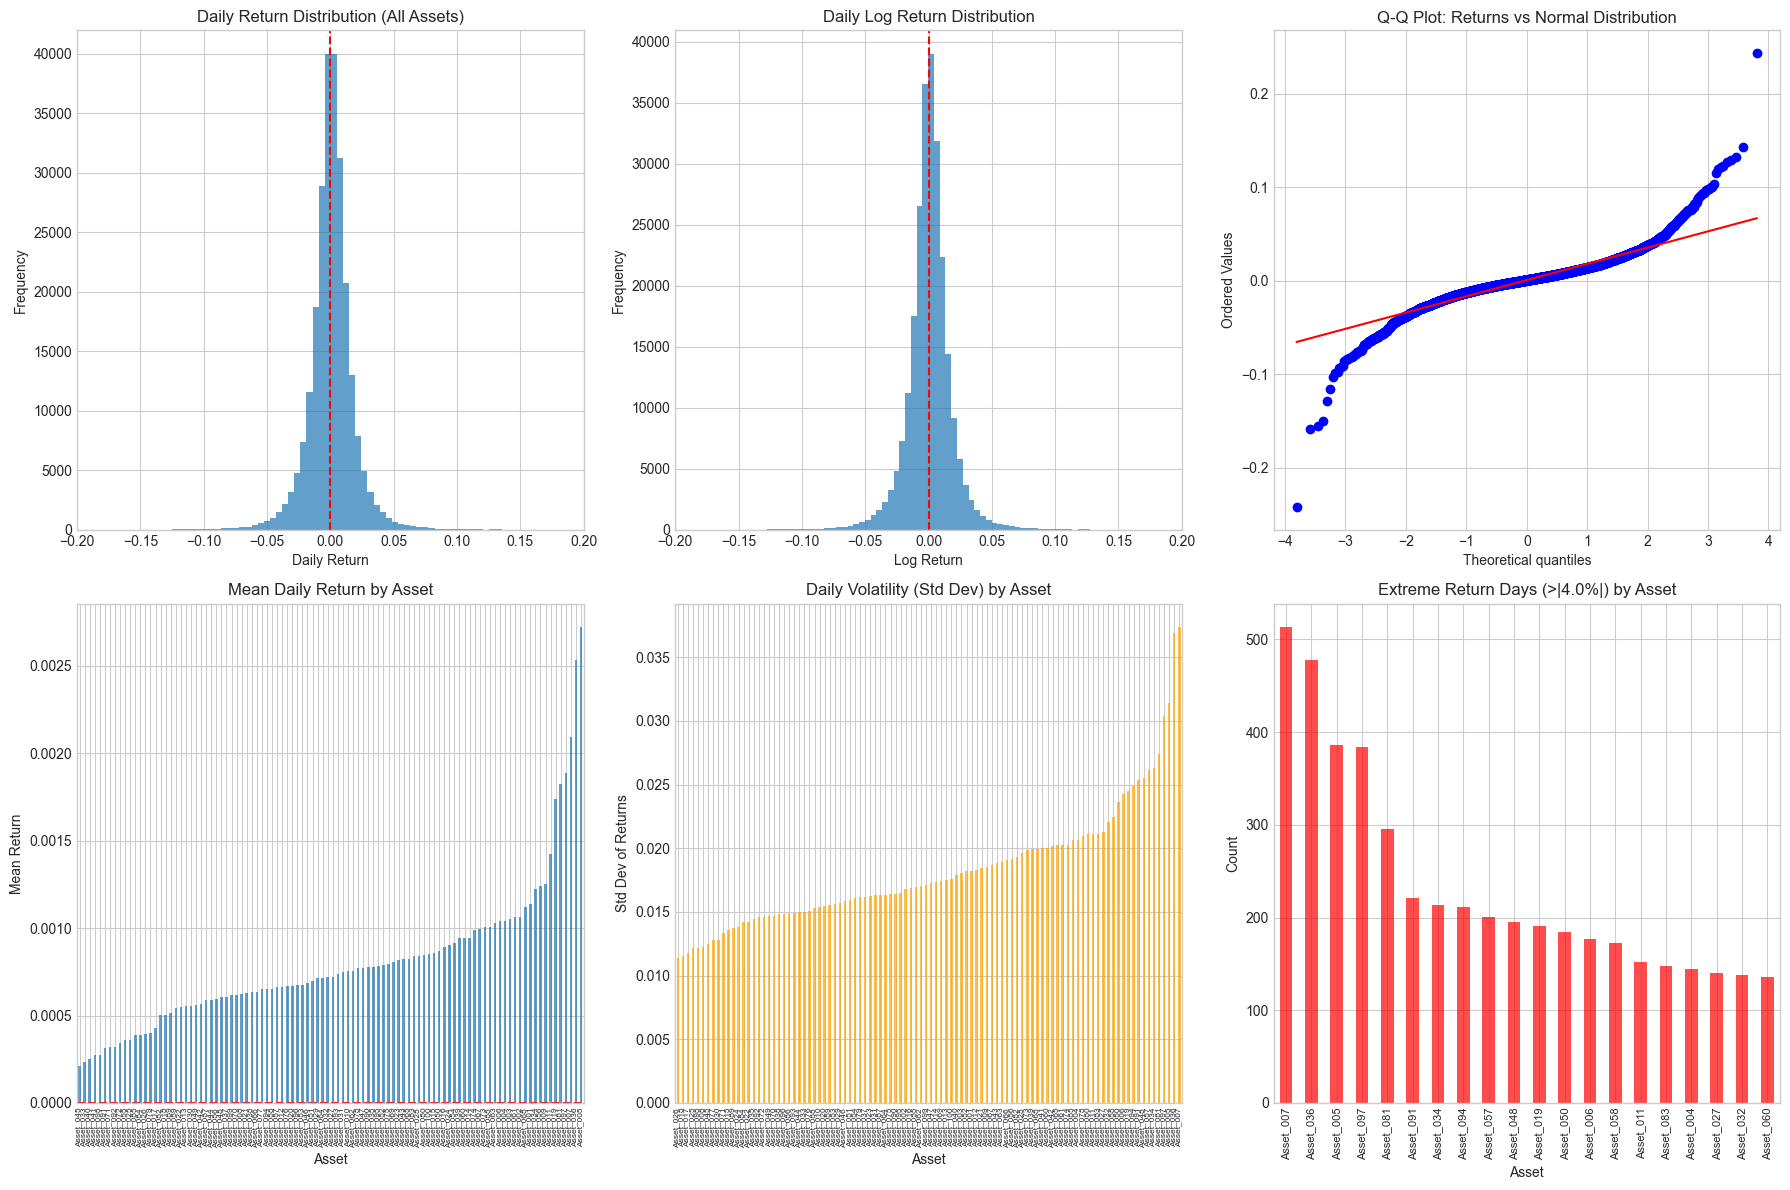


Overall Return Statistics:
count   251000.000000
mean         0.000799
std          0.018895
min         -0.351166
25%         -0.007424
50%          0.000816
75%          0.009144
max          0.612184
Name: returns, dtype: float64

Higher Moments:
  Skewness: 0.3051
  Kurtosis: 20.3451

📋 OBSERVATION: Extreme returns (>|4%|): 10,385 (4.1375%)


In [37]:
# =============================================================================
# 4.5 RETURN ANALYSIS (FIXED)
# =============================================================================

if close_col:
    # Sort and reset index first (Good practice, you already had this)
    df = df.sort_values([date_col, 'asset_id'] if date_col else ['asset_id']).reset_index(drop=True)

    # --- THE FIX ---
    # Use transform() to keep the index aligned with df
    
    # 1. Simple Returns
    # Note: pct_change() is a Series method, so we wrap it in a lambda for transform
    df['returns'] = df.groupby('asset_id')[close_col].transform(lambda x: x.pct_change())

    # 2. Log Returns
    # transform() ensures the result maps 1-to-1 with the original rows
    df['log_returns'] = df.groupby('asset_id')[close_col].transform(lambda x: np.log(x / x.shift(1)))
    
    # -----------------------------------------------
    
    # Remove first row of each asset (NaN return)
    returns_data = df.dropna(subset=['returns'])
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Return distribution
    ax1 = axes[0, 0]
    returns_data['returns'].hist(bins=200, ax=ax1, edgecolor='none', alpha=0.7)
    ax1.set_title('Daily Return Distribution (All Assets)')
    ax1.set_xlabel('Daily Return')
    ax1.set_ylabel('Frequency')
    ax1.axvline(0, color='r', linestyle='--')
    ax1.set_xlim(-0.2, 0.2)  # Focus on main distribution
    
    # Log return distribution
    ax2 = axes[0, 1]
    returns_data['log_returns'].dropna().hist(bins=200, ax=ax2, edgecolor='none', alpha=0.7)
    ax2.set_title('Daily Log Return Distribution')
    ax2.set_xlabel('Log Return')
    ax2.set_ylabel('Frequency')
    ax2.axvline(0, color='r', linestyle='--')
    ax2.set_xlim(-0.2, 0.2)
    
    # QQ plot (normality check)
    ax3 = axes[0, 2]
    sample_returns = returns_data['returns'].dropna().sample(min(10000, len(returns_data)))
    stats.probplot(sample_returns, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot: Returns vs Normal Distribution')
    
    # Return statistics by asset
    ax4 = axes[1, 0]
    asset_return_stats = returns_data.groupby('asset_id')['returns'].agg(['mean', 'std', 'skew'])
    asset_return_stats['mean'].sort_values().plot(kind='bar', ax=ax4, alpha=0.7)
    ax4.set_title('Mean Daily Return by Asset')
    ax4.set_xlabel('Asset')
    ax4.set_ylabel('Mean Return')
    ax4.tick_params(axis='x', rotation=90, labelsize=6)
    ax4.axhline(0, color='r', linestyle='--')
    
    # Volatility by asset
    ax5 = axes[1, 1]
    asset_return_stats['std'].sort_values().plot(kind='bar', ax=ax5, alpha=0.7, color='orange')
    ax5.set_title('Daily Volatility (Std Dev) by Asset')
    ax5.set_xlabel('Asset')
    ax5.set_ylabel('Std Dev of Returns')
    ax5.tick_params(axis='x', rotation=90, labelsize=6)
    
    # Extreme returns analysis
    ax6 = axes[1, 2]
    extreme_threshold = 0.04  # 10% daily move
    extreme_returns = returns_data[returns_data['returns'].abs() > extreme_threshold]
    extreme_counts = extreme_returns.groupby('asset_id').size().sort_values(ascending=False)
    extreme_counts.head(20).plot(kind='bar', ax=ax6, alpha=0.7, color='red')
    ax6.set_title(f'Extreme Return Days (>|{extreme_threshold*100}%|) by Asset')
    ax6.set_xlabel('Asset')
    ax6.set_ylabel('Count')
    ax6.tick_params(axis='x', rotation=90, labelsize=8)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FIGURES / 'return_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Return statistics
    print(f"\nOverall Return Statistics:")
    print(returns_data['returns'].describe())
    
    # Higher moments
    print(f"\nHigher Moments:")
    print(f"  Skewness: {returns_data['returns'].skew():.4f}")
    print(f"  Kurtosis: {returns_data['returns'].kurtosis():.4f}")
    
    # Extreme returns
    print(f"\n📋 OBSERVATION: Extreme returns (>|4%|): {len(extreme_returns):,} ({len(extreme_returns)/len(returns_data)*100:.4f}%)")


4.6 CROSS-ASSET CORRELATION ANALYSIS


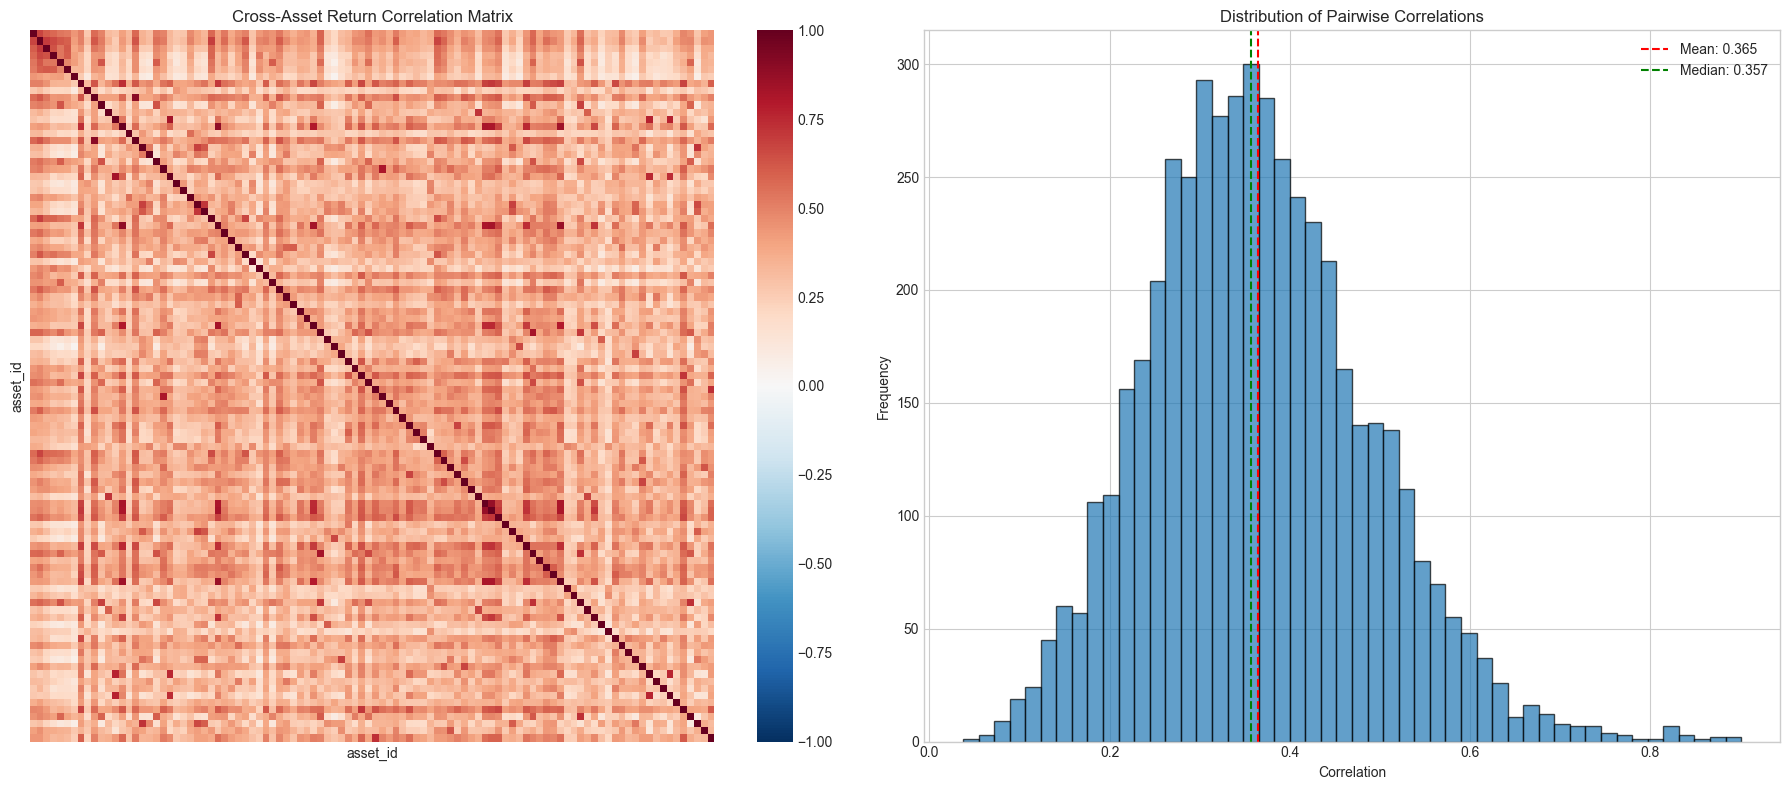


Correlation Statistics:
  Mean correlation: 0.3651
  Median correlation: 0.3569
  Std of correlations: 0.1210
  Min correlation: 0.0373
  Max correlation: 0.9006

📋 OBSERVATION: Highly correlated pairs (|corr| > 0.8): 16


,asset_1,asset_2,correlation
0,Asset_010,Asset_016,0.900560
2,Asset_014,Asset_028,0.884167
13,Asset_067,Asset_068,0.867961
11,Asset_028,Asset_078,0.867136
6,Asset_014,Asset_078,0.851246
8,Asset_028,Asset_042,0.834485
10,Asset_028,Asset_068,0.832917
1,Asset_013,Asset_021,0.832067
12,Asset_043,Asset_074,0.831222
4,Asset_014,Asset_067,0.820579


In [38]:
# =============================================================================
# 4.6 CROSS-ASSET CORRELATION ANALYSIS
# =============================================================================

print("\n" + "=" * 60)
print("4.6 CROSS-ASSET CORRELATION ANALYSIS")
print("=" * 60)

if date_col and close_col:
    # Pivot to get returns matrix
    returns_pivot = returns_data.pivot_table(
        index=date_col, 
        columns='asset_id', 
        values='returns'
    )
    
    # Calculate correlation matrix
    corr_matrix = returns_pivot.corr()
    
    # Visualize correlation matrix
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Full correlation heatmap
    ax1 = axes[0]
    sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, ax=ax1, 
                xticklabels=False, yticklabels=False,
                vmin=-1, vmax=1)
    ax1.set_title('Cross-Asset Return Correlation Matrix')
    
    # Correlation distribution
    ax2 = axes[1]
    # Get upper triangle (excluding diagonal)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_values = upper_tri.stack().values
    ax2.hist(corr_values, bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(corr_values.mean(), color='r', linestyle='--', label=f'Mean: {corr_values.mean():.3f}')
    ax2.axvline(np.median(corr_values), color='g', linestyle='--', label=f'Median: {np.median(corr_values):.3f}')
    ax2.set_title('Distribution of Pairwise Correlations')
    ax2.set_xlabel('Correlation')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FIGURES / 'correlation_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Correlation statistics
    print(f"\nCorrelation Statistics:")
    print(f"  Mean correlation: {corr_values.mean():.4f}")
    print(f"  Median correlation: {np.median(corr_values):.4f}")
    print(f"  Std of correlations: {corr_values.std():.4f}")
    print(f"  Min correlation: {corr_values.min():.4f}")
    print(f"  Max correlation: {corr_values.max():.4f}")
    
    # Highly correlated pairs
    high_corr_threshold = 0.8
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
                high_corr_pairs.append({
                    'asset_1': corr_matrix.columns[i],
                    'asset_2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    print(f"\n📋 OBSERVATION: Highly correlated pairs (|corr| > {high_corr_threshold}): {len(high_corr_pairs)}")
    if len(high_corr_pairs) > 0:
        high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
        display(high_corr_df.head(10))

In [39]:
# =============================================================================
# 4.7 OUTLIER DETECTION
# =============================================================================

print("\n" + "=" * 60)
print("4.7 OUTLIER DETECTION")
print("=" * 60)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Detect outliers using Z-score method."""
    z_scores = np.abs(stats.zscore(series.dropna()))
    return z_scores > threshold

def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Detect outliers using IQR method.""" 
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (series < lower_bound) | (series > upper_bound)

# Detect outliers in returns
if 'returns' in df.columns:
    returns_clean = df['returns'].dropna()
    
    # Z-score outliers
    zscore_outliers = detect_outliers_zscore(returns_clean, threshold=3.0)
    n_zscore_outliers = zscore_outliers.sum()
    
    # IQR outliers
    iqr_outliers = detect_outliers_iqr(returns_clean, k=1.5)
    n_iqr_outliers = iqr_outliers.sum()
    
    print(f"\nReturn Outlier Detection:")
    print(f"  Z-score method (|z| > 3): {n_zscore_outliers:,} ({n_zscore_outliers/len(returns_clean)*100:.2f}%)")
    print(f"  IQR method (k=1.5): {n_iqr_outliers:,} ({n_iqr_outliers/len(returns_clean)*100:.2f}%)")

# Detect outliers in prices
if close_col:
    # Price outliers by asset (compare within asset)
    price_outliers_by_asset = df.groupby('asset_id')[close_col].apply(
        lambda x: detect_outliers_zscore(x, threshold=4.0).sum()
    )
    
    print(f"\nPrice outliers by asset (Z-score > 4):")
    print(price_outliers_by_asset.describe())
    
    if price_outliers_by_asset.sum() > 0:
        print(f"\nAssets with most price outliers:")
        print(price_outliers_by_asset.nlargest(10))


4.7 OUTLIER DETECTION

Return Outlier Detection:
  Z-score method (|z| > 3): 4,187 (1.67%)
  IQR method (k=1.5): 16,263 (6.48%)

Price outliers by asset (Z-score > 4):
count   100.000000
mean      0.640000
std       3.680470
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      31.000000
Name: Close, dtype: float64

Assets with most price outliers:
asset_id
Asset_097    31
Asset_078    17
Asset_081    11
Asset_047     3
Asset_019     1
Asset_067     1
Asset_001     0
Asset_002     0
Asset_003     0
Asset_004     0
Name: Close, dtype: int64



4.8 MULTI-ASSET PRICE EVOLUTION (100 STOCKS)
Plotting 100 assets over full period
Date range: 2016-01-25 to 2026-01-16



4.8 MULTI-ASSET PRICE EVOLUTION (100 STOCKS)
Plotting 100 assets over full period
Date range: 2016-01-25 to 2026-01-16


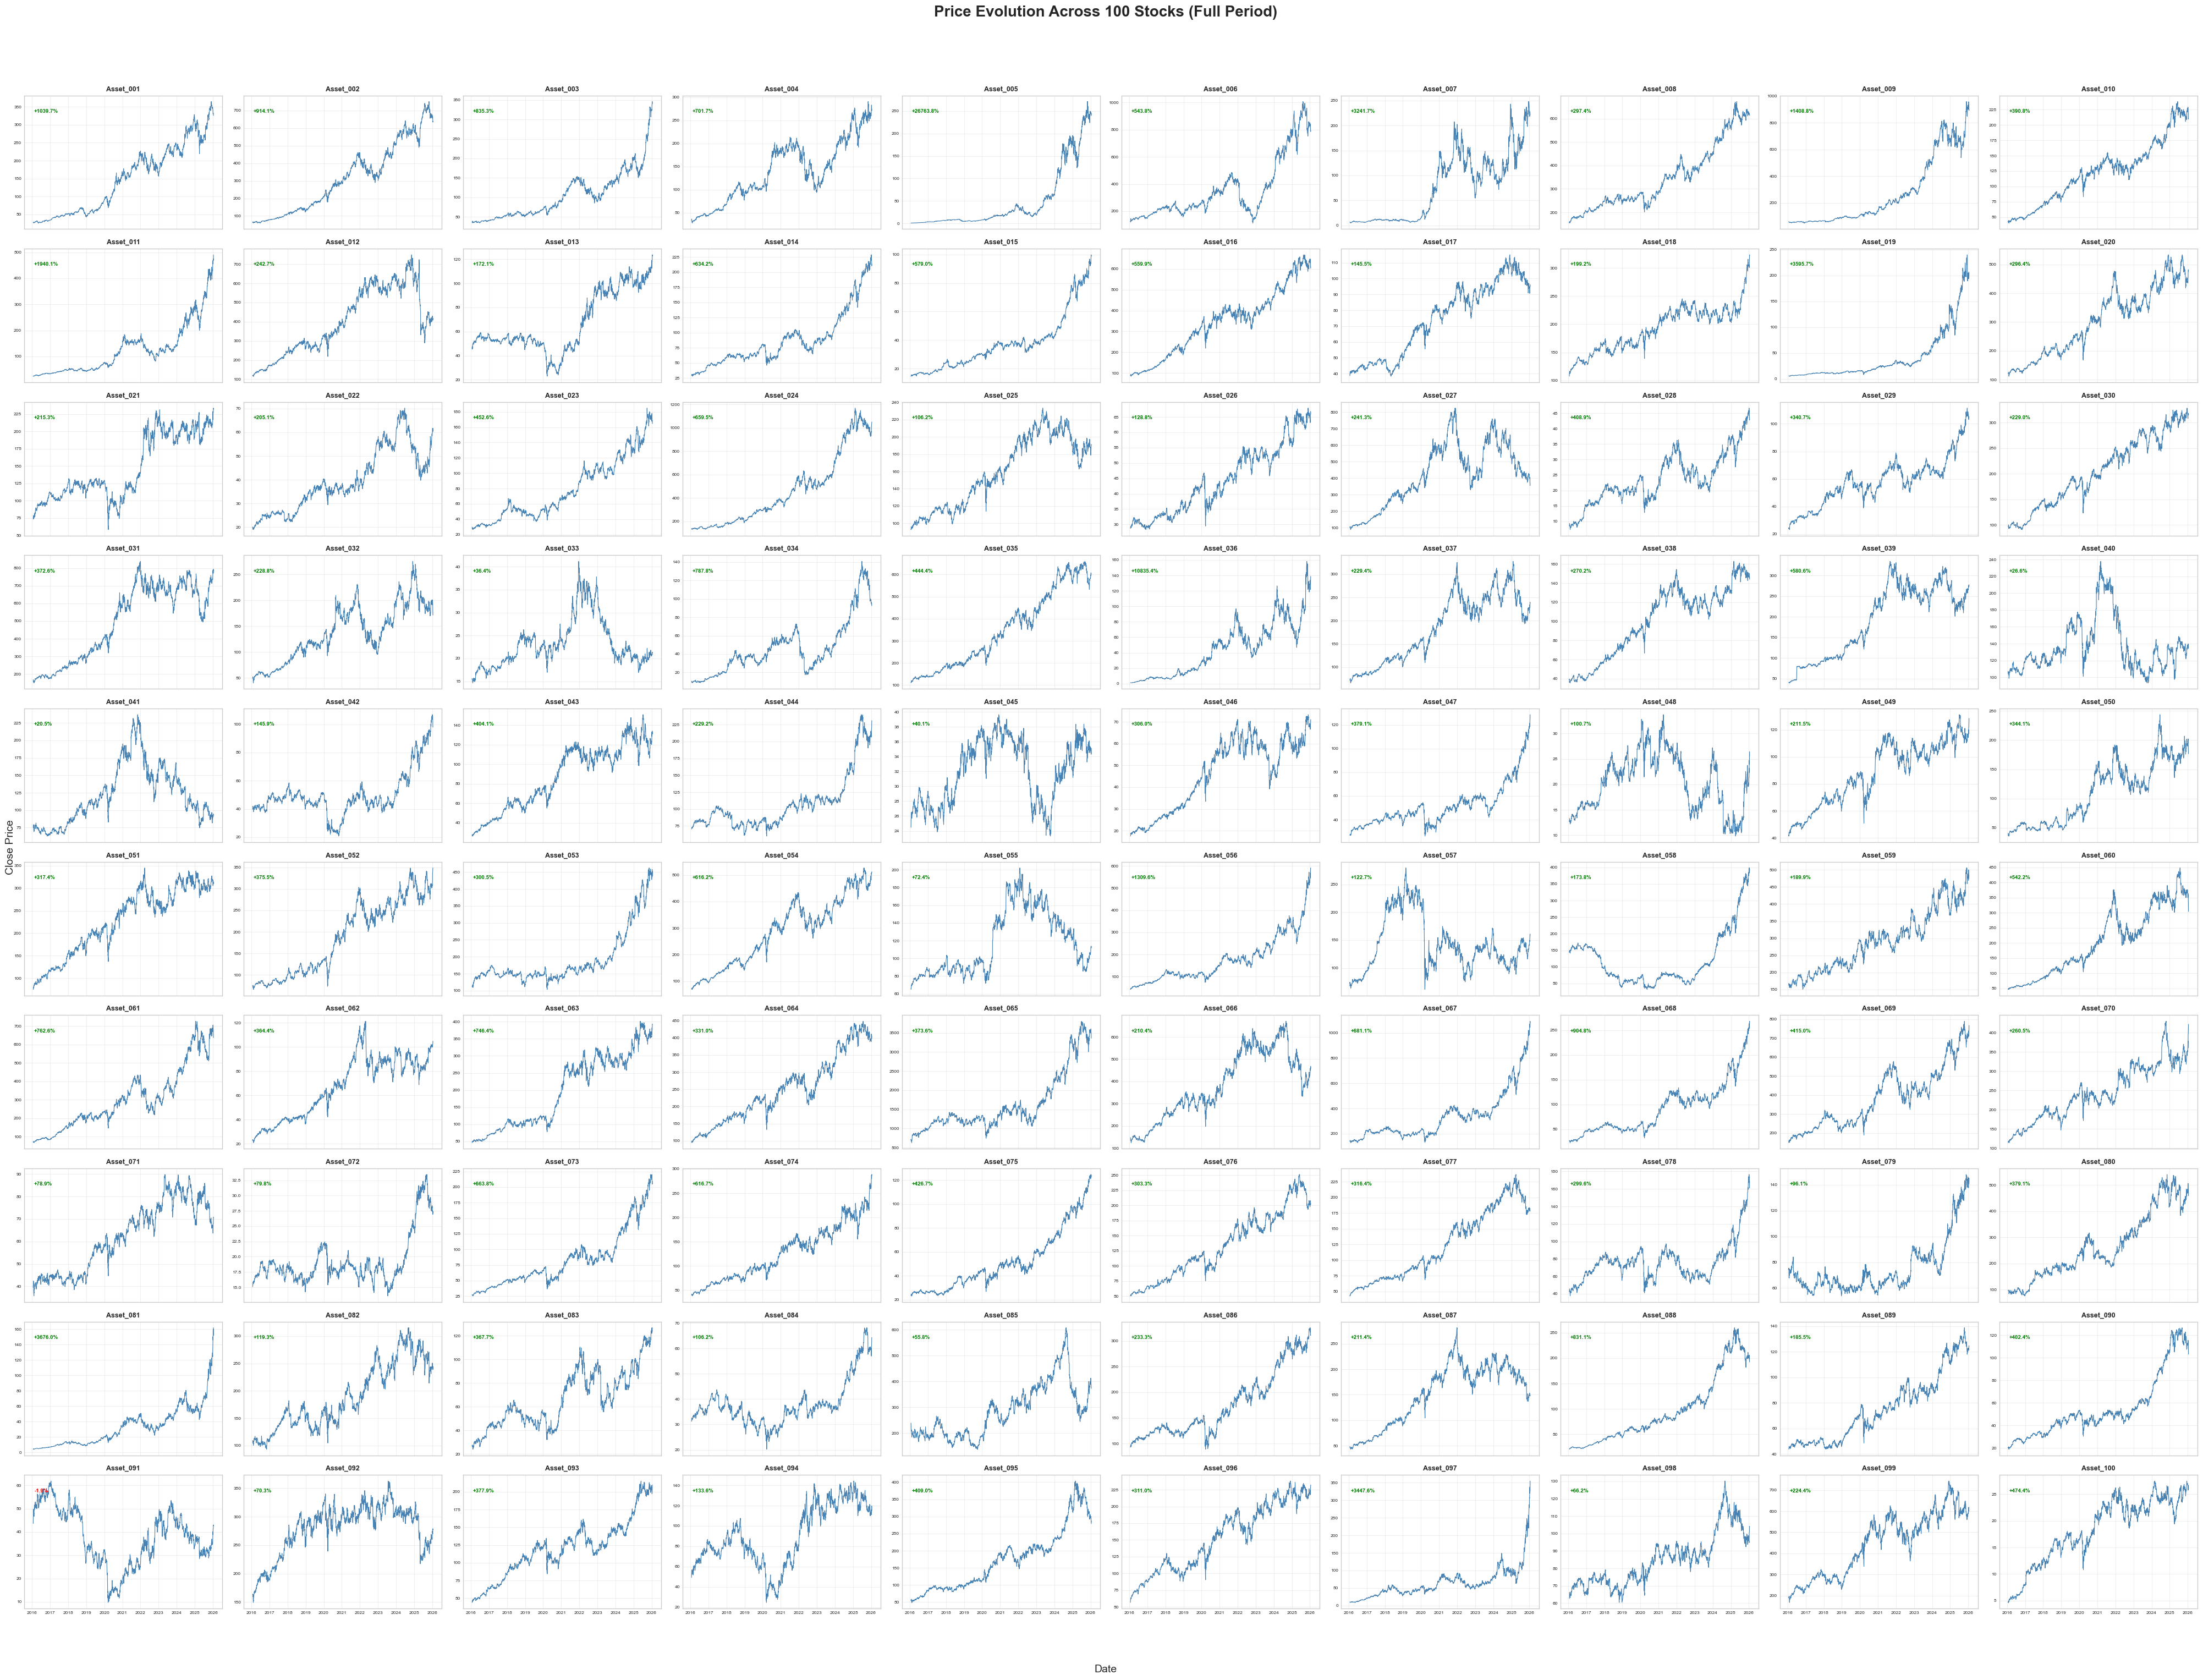


📋 OBSERVATION: Figure saved to outputs/figures/multi_asset_price_evolution_100.png


In [44]:
# =============================================================================
# 4.8 MULTI-ASSET PRICE EVOLUTION VISUALIZATION
# =============================================================================

print("\n" + "=" * 60)
print("4.8 MULTI-ASSET PRICE EVOLUTION (100 STOCKS)")
print("=" * 60)

# Select 100 stocks - spread across the universe for diversity
all_assets = sorted(df['asset_id'].unique())
n_to_plot = 100  # <--- CHANGED TO 100

# Sample evenly across the sorted asset list for diversity
step = max(1, len(all_assets) // n_to_plot)
selected_assets = all_assets[::step][:n_to_plot]

print(f"Plotting {len(selected_assets)} assets over full period")
print(f"Date range: {df[date_col].min().date()} to {df[date_col].max().date()}")

# Create figure with subplots (10x10 Grid)
# Increased figsize to (40, 30) to accommodate the density
fig, axes = plt.subplots(10, 10, figsize=(40, 30), sharex=True)
axes = axes.flatten()

for idx, asset in enumerate(selected_assets):
    ax = axes[idx]
    asset_data = df[df['asset_id'] == asset].sort_values(date_col)
    
    # Plot close price
    ax.plot(asset_data[date_col], asset_data[close_col], linewidth=0.8, color='steelblue')
    
    # Formatting
    # Reduced font sizes slightly to fit the tighter grid
    ax.set_title(asset, fontsize=9, fontweight='bold')
    ax.tick_params(axis='both', labelsize=6) 
    ax.grid(True, alpha=0.3)
    
    # Add some stats as text
    if len(asset_data) > 0:
        pct_change = ((asset_data[close_col].iloc[-1] / asset_data[close_col].iloc[0]) - 1) * 100
        color = 'green' if pct_change > 0 else 'red'
        ax.text(0.05, 0.90, f'{pct_change:+.1f}%', transform=ax.transAxes, 
                fontsize=7, verticalalignment='top', color=color, fontweight='bold')

# Remove empty subplots if any
for idx in range(len(selected_assets), len(axes)):
    fig.delaxes(axes[idx])

# Common labels
fig.suptitle('Price Evolution Across 100 Stocks (Full Period)', fontsize=20, fontweight='bold', y=1.01)
fig.text(0.5, 0.0, 'Date', ha='center', fontsize=14)
fig.text(0.0, 0.5, 'Close Price', va='center', rotation='vertical', fontsize=14)

# Use constrained_layout or tight_layout with padding
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.savefig(OUTPUT_FIGURES / 'multi_asset_price_evolution_100.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📋 OBSERVATION: Figure saved to outputs/figures/multi_asset_price_evolution_100.png")

## 5. Hypothesis Log

### Observations & Questions for Further Investigation

Based on the EDA, we document observations (NOT conclusions) that warrant further investigation:

| # | Observation | Potential Implication | Action Item |
|---|-------------|----------------------|-------------|
| 1 | [Fill based on EDA results] | | |
| 2 | | | |
| 3 | | | |

**Note:** These are hypotheses to test, not conclusions. We will validate or reject them with rigorous analysis.

In [42]:
# =============================================================================
# SAVE EDA SUMMARY
# =============================================================================

# Create EDA summary dictionary
eda_summary = {
    'data_shape': df.shape,
    'n_assets': df['asset_id'].nunique(),
    'date_range': [str(df[date_col].min()), str(df[date_col].max())] if date_col else None,
    'columns': list(df.columns),
    'ohlcv_mapping': ohlcv_mapping,
    'quality_report': assessor.get_summary()
}

print("\n" + "=" * 60)
print("EDA SUMMARY SAVED")
print("=" * 60)
print(f"Data shape: {eda_summary['data_shape']}")
print(f"Number of assets: {eda_summary['n_assets']}")
print(f"Date range: {eda_summary['date_range']}")
print(f"OHLCV mapping: {eda_summary['ohlcv_mapping']}")


EDA SUMMARY SAVED
Data shape: (251100, 10)
Number of assets: 100
Date range: ['2016-01-25 00:00:00', '2026-01-16 00:00:00']
OHLCV mapping: {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}


---

## 6. Next Steps

After completing EDA, the next phase involves:

1. **Data Cleaning** - Address issues identified above
2. **Feature Engineering** - Generate predictive features
3. **Save Processed Data** - Export cleaned dataset

Continue in the cells below or in Part 1B notebook.

---

In [43]:
# =============================================================================
# CHECKPOINT: SAVE WORKING DATA
# =============================================================================

# Save the current state for next notebook/session
df.to_parquet(DATA_PROCESSED / 'df_after_eda.parquet', index=False)
print(f"✓ Saved working data to: {DATA_PROCESSED / 'df_after_eda.parquet'}")

✓ Saved working data to: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\df_after_eda.parquet
